## Waveform spatial variation

author: laquitainesteeve@gmail.com

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM (GPU not needed)

Execution time: 40 secs

Method:
- We normalize all waveforms to start at x=0 at y=0 at and to be time-centered at site location, to clearly see the polarity reversal near the soma. 
- All waveform min-max amplitudes are normalized to be the same to facilitate visibility and to focus on the comparison of their shapes.
- Datasets:
    - sub-biophy-isolated-traces-reyes_ses-006_ecephys.nwb on dandi archive
        - Recording extractor with 8x16 electrode Reyes probe, not aligned along the vertical axis of the cortical column.
        - Ground truth spikes of cell 3754013 
    - assets/morph_cell_3754013.h5 in github repository

## Setup

Create and activate envs/spikebias.yml environment kernel.

In [ ]:
%%time
import os
import neurom as nm
from neurom.view import plotly_impl
from neurom.view import matplotlib_impl
import yaml 
import spikeinterface as si
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt;
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", module="matplotlib")
print('Spikeinterface version:', si.__version__)

# move to project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(proj_path)

# setup cell parameters
CELL = '3754013'                                                  # the most active pyramidal cell (layer 5)
CELL_POS = np.array([3820.476353, -1143.5028, -2538.452514])    # its position in the cortical column

# setup paths
RECORDING_PATH = 'dataset/00_raw/recording_reyes_isolated_traces'
GT_PATH = 'dataset/00_raw/ground_truth_reyes_isolated_traces'

# install chrome to save as svg figures
!plotly_get_chrome -y

# setup waveform parameters
MS_BEFORE = 10

# figure axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

# figure save
savefig_cfg = {"transparent":True, "dpi": 400}
savefig_png_cfg = {"transparent":True, "dpi": 900}

legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.5}

Spikeinterface version: 0.100.5
Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
CPU times: user 662 ms, sys: 139 ms, total: 801 ms
Wall time: 36.4 s


## Functions

In [ ]:
def get_unit_waveform(trace, spike_time, timepoint_before=60, timepoint_after=60):
    """
    Extracts waveforms of a unit from the given trace based on spike times.

    Parameters:
        trace (numpy.ndarray): The signal trace from which waveforms are extracted.
        spike_time (list or numpy.ndarray): The spike times (in samples) for the unit.
        timepoint_before (int): Number of samples to include before the spike time.
        timepoint_after (int): Number of samples to include after the spike time.

    Returns:
        list: A list of waveforms, each corresponding to a spike.
    """
    waveform = []
    for spike in spike_time:
        this_waveform = trace[
            int(spike - timepoint_before) : int(spike + timepoint_after)
        ]
        waveform.append(this_waveform)
    return waveform


def shrink_to_mean(arr, factor=0.5):
    mean = arr.mean()
    return mean + (arr - mean) * factor


## Load dataset

In [ ]:
# load ground truth 
Recording = si.load_extractor(RECORDING_PATH)             # recording traces
Gt = si.load_extractor(GT_PATH)                           # ground truth spike timestamps
cell = nm.load_morphology("assets/morph_cell_3754013.h5") # cell morphology data

## Compute data

In [ ]:
%%time 

# color legend defined in neurom.view.matplotlib_impl.py
#     NeuriteType.basal_dendrite: 'red',
#     NeuriteType.apical_dendrite: 'purple',
#     NeuriteType.axon: 'blue',
#     NeuriteType.soma: 'black',
#     NeuriteType.undefined: 'green',
#     NeuriteType.custom5: 'orange',
#     NeuriteType.custom6: 'orange',
#     NeuriteType.custom7: 'orange',
#     NeuriteType.custom8: 'orange',
#     NeuriteType.custom9: 'orange',
#     NeuriteType.custom10: 'orange',


# get electrode positions
site_pos = si.load_extractor(RECORDING_PATH).get_property('location')
print("site coordinates:\n", site_pos)

# get spike train
spike_sample = Gt.get_unit_spike_train(CELL)

# get traces and its parameters
cell_traces = Recording.get_traces()
rec_duration_sec = Recording.get_total_duration()
sfreq = Recording.sampling_frequency
timepoints_before = MS_BEFORE * sfreq / 1000
time_sec = np.arange(0, rec_duration_sec, 1 / sfreq)

# calculate median spike (template) per channel (1 sec)
contact_ids = np.arange(0, 128, 1)

# get all waveforms by electrode site
wavef_by_channel = []
for channel_i in range(len(contact_ids)):
    wvs = get_unit_waveform(
        cell_traces[:, channel_i],
        spike_sample,
        timepoint_before=timepoints_before,
        timepoint_after=timepoints_before,
    )
    min_len = min([len(ix) for ix in wvs])
    wv2 = []
    for wv in wvs:
        wv2.append(wv[:min_len])
    mean_wavef = np.mean(np.array(wv2), axis=0)
    wavef_by_channel.append(mean_wavef)
all_spikes = np.array(wavef_by_channel)
all_spikes = all_spikes.T

# setup electrode site ids in an array
contact_ids = np.arange(0, 128, 1)
contact_grid = contact_ids.reshape(8, 16)

# setup waveform negative peak-to- positive peak color schemes
# - get peak to peak amplitude (ppa)
min_s = all_spikes.min(axis=0)
max_s = all_spikes.max(axis=0)
peak_to_peak_amp = max_s - min_s

# - map ppa to spike templates (logscale)
df = pd.DataFrame(
    {"ppa": np.log10(peak_to_peak_amp), "contact": np.arange(0, 128, 1)}
).sort_values(by="ppa", ascending=True)

# - convert peak to peak amplitude to color gradient
color_intensity = (df["ppa"] - df["ppa"].min()) / (df["ppa"].max() - df["ppa"].min())
cmap = plt.cm.viridis(color_intensity)
df["colors"] = cmap.tolist()
df = df.sort_values(by="contact")

# - convert colors to RGB for plotly
arr = np.array(df["colors"].values.tolist(), dtype=float)
rgba_colors = [f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})" for r, g, b, a in arr]

site coordinates:
 [[ 3333.81242423 -1841.70092968 -2941.78131262]
 [ 3378.99014513 -1853.02392971 -2882.99557282]
 [ 3424.16786603 -1864.34692974 -2824.20983301]
 [ 3469.34558693 -1875.66992978 -2765.42409321]
 [ 3514.52330784 -1886.99292981 -2706.63835341]
 [ 3559.70102874 -1898.31592985 -2647.8526136 ]
 [ 3604.87874964 -1909.63892988 -2589.0668738 ]
 [ 3650.05647054 -1920.96192992 -2530.28113399]
 [ 3695.23419145 -1932.28492995 -2471.49539419]
 [ 3740.41191235 -1943.60792999 -2412.70965439]
 [ 3785.58963325 -1954.93093002 -2353.92391458]
 [ 3830.76735415 -1966.25393005 -2295.13817478]
 [ 3875.94507506 -1977.57693009 -2236.35243498]
 [ 3921.12279596 -1988.89993012 -2177.56669517]
 [ 3966.30051686 -2000.22293016 -2118.78095537]
 [ 4011.47823777 -2011.54593019 -2059.99521557]
 [ 3382.43500685 -1647.70133056 -2941.78131262]
 [ 3427.61272776 -1659.02433059 -2882.99557282]
 [ 3472.79044866 -1670.34733062 -2824.20983301]
 [ 3517.96816956 -1681.67033066 -2765.42409321]
 [ 3563.14589046 -169

## Plot waveform variation

CPU times: user 992 ms, sys: 40.1 ms, total: 1.03 s
Wall time: 1.03 s


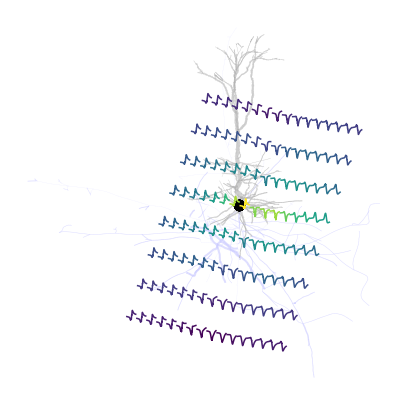

In [ ]:
%%time 

# setup parameters
Y_SCALE = 30
X_SHRINK = 0.1
ALPHA = 0.8
LW = 1

# setup plot
fig, ax = plt.subplots(figsize=(5, 5)) # width, height in inches

# color axon in blue
matplotlib_impl.plot_morph(cell, plane="xy", soma_outline=False, neurite_type=nm.NeuriteType.axon, color=(0.8,0.8,1), ax=ax, alpha=ALPHA, linewidth=LW)

# color basal dendrites in lighter grey
matplotlib_impl.plot_morph(cell, plane="xy", soma_outline=False, neurite_type=nm.NeuriteType.basal_dendrite, color=(0.7,0.7,0.7), ax=ax, alpha=ALPHA, linewidth=LW)

# color apical dendrites in lighter grey
matplotlib_impl.plot_morph(cell, plane="xy", soma_outline=False, neurite_type=nm.NeuriteType.apical_dendrite, color=(0.7,0.7,0.7), ax=ax, alpha=ALPHA, linewidth=LW)

# plot waveform at each electrode site
for s_ix in np.arange(0, 128):

    # setup waveforms
    # - center and scale waveform at electrode site
    waveform = all_spikes[:, s_ix]
    y_centered = (waveform - waveform.mean())
    y_normalized = 2 * (y_centered - y_centered.min()) / (y_centered.max() - y_centered.min())-1

    # - place waveform at site location
    wavform_x_centered = len(waveform)/2
    wave_x = site_pos[[s_ix], 0] - CELL_POS[0] + np.arange(0, len(waveform),1) - wavform_x_centered
    wave_x = shrink_to_mean(wave_x, X_SHRINK)

    # - scale waveform amplitude for visibility
    y_scaled = y_normalized * Y_SCALE # scale waveform for visibility
    y0_is_0 = y_scaled - y_scaled[0] # normalize all waveform to be 0 at x=0.
    wave_y = site_pos[[s_ix], 1] - CELL_POS[1] + y0_is_0

    # plot electrode site
    # translated to place the cell relative to the sites - we can't move the cell
    #ax.scatter(x = site_pos[[s_ix],0] - CELL_POS[0], y = site_pos[[s_ix],1] - CELL_POS[1], color='black', s=2, label='electrodes')

    # plot soma
    ax.plot(cell.soma.center[0], cell.soma.center[1], color='k', marker='o', markerfacecolor='k', markersize=7, linewidth=1, label='soma')

    # plot waveform at this site
    ax.plot(wave_x, wave_y, color=arr[s_ix,:], linewidth=1.1, label='waveform', zorder=1000)

# aesthetics
ax.set_title("")
ax.set_axis_off()

# save figure
plt.savefig("figures/7_reviews/fig3_D_isolated_waveform_spatial_variation.svg", **savefig_cfg)
plt.savefig("figures/7_reviews/fig3_D_isolated_waveform_spatial_variation.png", **savefig_png_cfg) # high resolution

## Plot Peak-to-peak amplitude variation

CPU times: user 301 ms, sys: 220 ms, total: 521 ms
Wall time: 230 ms


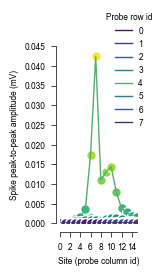

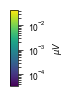

In [ ]:
%%time 

fig, ax = plt.subplots(figsize=(1, 2.3))

# setup electrode layout
contact_id = [
    np.arange(0, 16, 1),
    np.arange(16, 32, 1),
    np.arange(32, 48, 1),
    np.arange(48, 64, 1),
    np.arange(64, 80, 1),
    np.arange(80, 96, 1),
    np.arange(96, 112, 1),
    np.arange(112, 128, 1),
]

for row_i in range(len(contact_id)):
    for ix, c_id in enumerate(contact_id[row_i]):
        plt.plot(
            ix,
            peak_to_peak_amp[c_id],
            color=df["colors"].iloc[c_id],
            marker="o",
            markersize=7,
            markeredgecolor="w",
        )

    # row color is averaged color over row's contacts
    color_row = np.array(
        [color_i for color_i in df["colors"].loc[contact_id[row_i]]]
    ).mean(axis=0)
    plt.plot(
        peak_to_peak_amp[contact_id[row_i]],
        color=color_row,
        linewidth=1,
        label=f"{row_i}",
    )

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines[["right", "top"]].set_visible(False)
ax.set_xticks(np.arange(0, 15, 2))
ax.set_ylim([0, 0.045])
ax.set_xlim([0, 15])
ax.set_ylabel("Spike peak-to-peak amplitude (mV)")
ax.set_xlabel("Site (probe column id)")
legend = ax.legend(
    fontsize=6, title="Probe row id", frameon=False, bbox_to_anchor=(0.5, 0.5)
)

# save figure
plt.savefig("figures/7_reviews/fig3_E_peak_to_peak_amplitude_change.svg", **savefig_cfg)

# save log scale colorbar
fig, ax = plt.subplots(figsize=(0.1, 2))
fig.subplots_adjust(bottom=0.5)
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.LogNorm(vmin=peak_to_peak_amp.min(), vmax=peak_to_peak_amp.max())
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation="vertical", label="$\mu V$")

# save figure
plt.savefig("figures/7_reviews/fig3_D_E_colorbar.svg", bbox_inches='tight', **savefig_cfg)